The dataset consist of a track image and its corresponding steering angle as the label.

A single frame is used to predict the steering angle.

In [1]:
import pandas as pd
import json
import numpy as np
import os
import cv2
import  matplotlib.pyplot as plt
from sklearn.utils import  shuffle
import matplotlib.image as mpimg
from imgaug import  augmenters as iaa
import random
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D,Flatten,Dense,MaxPooling2D,Dropout,Cropping2D,Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.model_selection import train_test_split

In [2]:
def createModel():
    '''
    Function: createModel

    Creates a convolutional neural network (CNN) model .

    Description:
    This function constructs a Sequential model for image processing, specifically designed for autonomous vehicle applications. The model architecture consists of convolutional layers followed by fully connected layers.

    Returns:
    - A Keras Sequential model.
    
    '''
    
    model = Sequential()

    model.add(Convolution2D(24, (5, 5), (2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Convolution2D(36, (5, 5), (2, 2), activation='elu'))
    model.add(Convolution2D(48, (5, 5), (2, 2), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))

    model.add(Flatten())
    model.add(Dense(100, activation = 'elu'))
    model.add(Dense(50, activation = 'elu'))
    model.add(Dense(10, activation = 'elu'))
    model.add(Dense(1))

    model.compile(Adam(lr=0.0001),loss='mse')
    return model

In [3]:
def preprocessing(img,condition = True):
    
    '''
    Preprocess an input image before feeding to CNN network.

    Parameters:
    - img : numpy.ndarray
    The input image to be preprocessed.

    - condition : bool, optional, default: True
    A boolean flag indicating whether to apply the specified preprocessing steps. 
    If True, the image undergoes preprocessing; otherwise, the original image is returned.

    Returns:
    - Preprocessed image (numpy.ndarray) if condition is True; otherwise, the original image.

    '''
    
    if condition :
        img = img[120:,:,:]
        img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
        img = cv2.GaussianBlur(img,(3,3),0)
        img = cv2.resize(img,(200,66))
        img = img/255
        return img
    else :
        return img


In [4]:
def image_augmentation(imagePath,steering,show_result = False):
    '''
    Perform image augmentation on an input image for data augmentation.

    Parameters:
    - imagePath : str
    The file path to the input image.

    - steering : float
    The steering angle associated with the input image.

    - show_result : bool, optional, default: False
    A boolean flag indicating whether to display the augmented image alongside the original image for visual inspection.

    Returns:
    - Randomly Augmented image (numpy.ndarray) and the associated steering angle.
    
    '''
    img  = mpimg.imread(imagePath)
    temp = mpimg.imread(imagePath)
    temp = temp[120:,:,:]
    
    #####panning
    if np.random.rand() > 0.5:
        pan = iaa.Affine(translate_percent={'x':(-0.1,0.1),'y':(-0.1,0.1)})
        img = pan.augment_image(img)
        
    ######zoom
    if np.random.rand() > 0.5:
        zoom = iaa.Affine(scale=(1,1.2))
        img= zoom.augment_image(img)
        
    ##### changing brightness
    if np.random.rand() > 0.5:
        brightness = iaa.Multiply((0.4,1.2))
        img= brightness.augment_image(img)

    if show_result:
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(img)
        axarr[1].imshow(temp)
        plt.show()

    return img,steering

In [5]:
def grab_data(path,data):
    '''
    Load and organize image data and associated steering angles from a specified path.

    Parameters:
    - path : str
    The base path where the image data is stored.

    - data : pandas.DataFrame
    A DataFrame containing information about the image data, including file names and corresponding steering angles.

    Returns:
    - img_list : numpy.ndarray
    An array containing the file paths to the images.

    - steering_list : numpy.ndarray
    An array containing the associated steering angles.
    
    '''
    
    img_list = []
    steering_list = []

    for i in range(len(data)):
        img_list.append(os.path.join(path,'IMG',data.iloc[i][0]))
        steering_list.append(float(data.iloc[i][1]))

    img_list = np.asarray(img_list)
    steering_list = np.asarray(steering_list)

    return img_list,steering_list

In [6]:
def import_data(path):
    '''
    Import and organize driving data from a specified path.

    Parameters:
    - path : str
    The base path where the driving data file ('driving_log.csv') is located.

    Returns:
    - data : pandas.DataFrame
    A DataFrame containing organized driving data with columns 'Center' (file paths) and 'Steering' (steering angles).

    
    '''
    
    columns = ['Center','Steering']
    data = pd.read_csv(os.path.join(path, 'driving_log.csv'),names= columns)
    data['Center'] = data['Center'].apply(getLast)
    #print(getLast(data['Center'][0]))
    return data

In [7]:
def balanceData(data,max_bin = 400):
    ''' 
    Balance the distribution of data samples based on the 'Steering' column.

    Parameters:
    - data (pd.DataFrame): Input DataFrame containing a 'Steering' column to balance.
    - max_bin (int): Maximum number of samples to retain per bin. Default is 400.

    Returns:
    - pd.DataFrame: Balanced DataFrame.

    '''

    nbin = 25
    noSample = max_bin
    hist, bins = np.histogram(data['Steering'],nbin)
    center = (bins[1:]+bins[:-1])*0.5
    plt.bar(center,hist,width = 0.05)
    plt.plot((-1,1),(noSample,noSample),linewidth= 1)
    plt.show()

    #print(bins)
    to_remove = []

    for i in range(nbin):
        binlist = []
        for j in range(len(data['Steering'])):
            if data['Steering'][j] >= bins[i] and data['Steering'][j] <= bins[i+1]:
                binlist.append(j)
                binlist = shuffle(binlist)
        to_remove.extend(binlist[noSample:])

    data.drop(data.index[to_remove],inplace = True)

    hist, bins = np.histogram(data['Steering'],nbin)
    center = (bins[1:]+bins[:-1])*0.5
    plt.bar(center,hist,width = 0.05)
    plt.plot((-1,1),(noSample,noSample),linewidth= 1)
    plt.show()

    return data

In [8]:
def getLast(Filepath):
    return Filepath.split('\\')[-1]

In [9]:
def batchGenerator(image_path,steering_list,batchSize = 100,isTraining = True,pre_processing = True):
    '''
    Generate batches of images and corresponding steering angles for training or validation.

    Parameters:
    - image_path (list): List of file paths to images.
    - steering_list (list): List of steering angles corresponding to the images.
    - batchSize (int): Number of samples per batch. Default is 100.
    - isTraining (bool): Flag indicating whether the generator is used for training. Default is True. 
       If training image augmentation will be applied
    - pre_processing (bool): Flag indicating whether to apply preprocessing to the images. Default is True.

    Yields:
    - tuple: A tuple containing a batch of preprocessed images and their corresponding steering angles.
    '''
    
    
    
    while True:
        imageBatch = []
        steeringBatch = []
        for i in range(batchSize):
            index = random.randint(0,len(image_path)-1)
            if isTraining:
                img,steering = image_augmentation(image_path[index],steering_list[index])
            else:
                img  = mpimg.imread(image_path[index])
                steering = steering_list[index]
                
            if pre_processing :
                imageBatch.append(preprocessing(img))
            else :
                imageBatch.append(img)
            steeringBatch.append(steering)
        yield (np.asarray(imageBatch),np.asarray(steeringBatch))

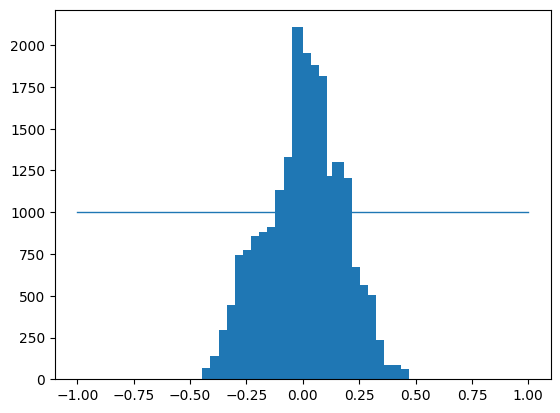

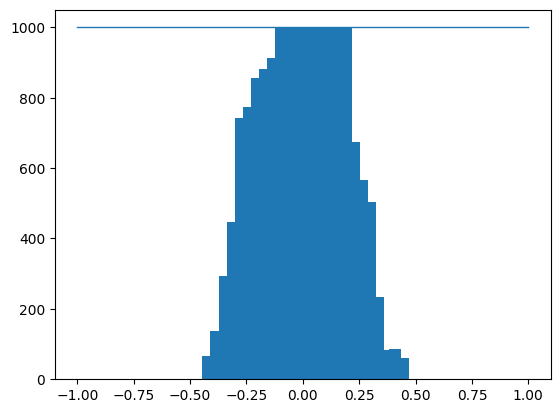

16315


In [10]:
path = "Data"
data = import_data(path)
balanced_data = balanceData(data,1000)
imagePath_list,steering_list = grab_data(path,balanced_data)
print(len(imagePath_list))

In [11]:
img_train,img_valid,steering_train,steering_valid = train_test_split(imagePath_list,steering_list,test_size = 0.2 , random_state = 5)

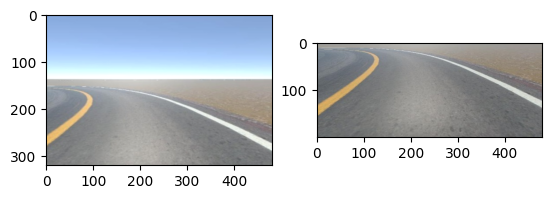

In [12]:
_,_ = image_augmentation(imagePath_list[500],steering_list[500],show_result = True)

(66, 200, 3)


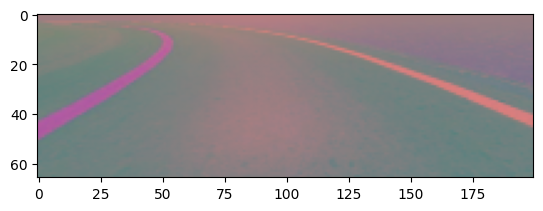

In [13]:
#preprocess image
img  = mpimg.imread(imagePath_list[500])
img = preprocessing(img, condition = True)
imgplot = plt.imshow(img)
print(img.shape)

In [14]:
model =createModel()

In [15]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               1

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
model_save_path = 'Models/CNN_checkpoint.h5'
checkpoint_callback = ModelCheckpoint(
    model_save_path,  # Specify the filepath to save the model
    save_weights_only=False,  # Save the entire model, including the architecture
    save_best_only=False,  # Save the model at every epoch
    verbose=0  # Show progress during saving
)

In [17]:
history = model.fit(batchGenerator(img_train,steering_train,batchSize=32 ,isTraining=True),steps_per_epoch= 20 , epochs =100,
validation_data=batchGenerator(img_valid,steering_valid,batchSize=32,isTraining=False),validation_steps=20,callbacks=[checkpoint_callback])

Epoch 1/100
20/20 [==============================] - 19s 961ms/step - loss: 0.0997 - val_loss: 0.0405
Epoch 2/100
20/20 [==============================] - 15s 787ms/step - loss: 0.0363 - val_loss: 0.0228
Epoch 3/100
20/20 [==============================] - 11s 576ms/step - loss: 0.0295 - val_loss: 0.0138
Epoch 4/100
20/20 [==============================] - 9s 446ms/step - loss: 0.0275 - val_loss: 0.0111
Epoch 5/100
20/20 [==============================] - 11s 553ms/step - loss: 0.0243 - val_loss: 0.0085
Epoch 6/100
20/20 [==============================] - 13s 670ms/step - loss: 0.0252 - val_loss: 0.0058
Epoch 7/100
20/20 [==============================] - 13s 657ms/step - loss: 0.0215 - val_loss: 0.0044
Epoch 8/100
20/20 [==============================] - 12s 649ms/step - loss: 0.0184 - val_loss: 0.0051
Epoch 9/100
20/20 [==============================] - 14s 710ms/step - loss: 0.0244 - val_loss: 0.0051
Epoch 10/100
20/20 [==============================] - 10s 548ms/step - loss: 0.0214

Epoch 81/100
20/20 [==============================] - 7s 388ms/step - loss: 0.0051 - val_loss: 0.0021
Epoch 82/100
20/20 [==============================] - 9s 451ms/step - loss: 0.0047 - val_loss: 0.0025
Epoch 83/100
20/20 [==============================] - 10s 530ms/step - loss: 0.0052 - val_loss: 0.0026
Epoch 84/100
20/20 [==============================] - 11s 548ms/step - loss: 0.0051 - val_loss: 0.0031
Epoch 85/100
20/20 [==============================] - 10s 528ms/step - loss: 0.0047 - val_loss: 0.0027
Epoch 86/100
20/20 [==============================] - 11s 566ms/step - loss: 0.0045 - val_loss: 0.0027
Epoch 87/100
20/20 [==============================] - 8s 420ms/step - loss: 0.0041 - val_loss: 0.0025
Epoch 88/100
20/20 [==============================] - 7s 390ms/step - loss: 0.0043 - val_loss: 0.0025
Epoch 89/100
20/20 [==============================] - 8s 404ms/step - loss: 0.0060 - val_loss: 0.0036
Epoch 90/100
20/20 [==============================] - 9s 451ms/step - loss: 0.

In [18]:
model.save("CNN_model.h5")

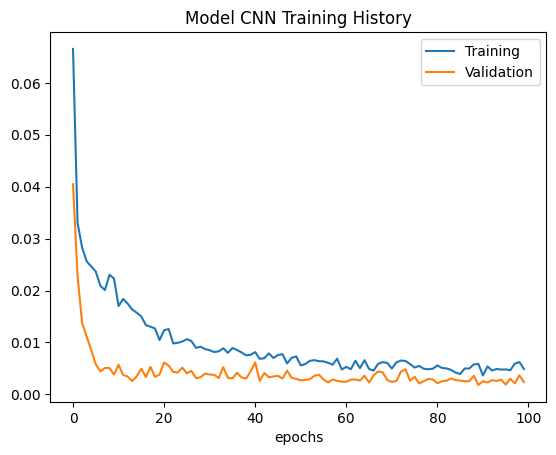

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training','Validation'])
plt.title('Model CNN Training History')
plt.xlabel('epochs')
plt.show()

In [20]:
from tensorflow.keras.models import load_model

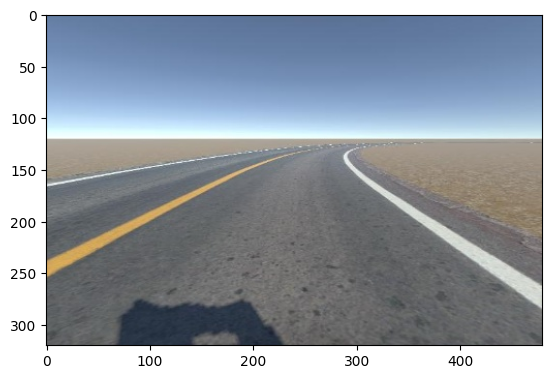

In [21]:
img = cv2.imread("Data/IMG/2023_12_01_19_29_07_1.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [22]:
model = load_model('CNN_model.h5')
img = preprocessing(img)
img = np.expand_dims(img,axis = 0)
print(img.shape)
steering  = model.predict(img)
print(steering[0][0])

(1, 66, 200, 3)
-0.05606385
